In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import backend as K

In [ ]:
# Load data
(x_train, _), (x_test, _) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [ ]:
#Parameters
input_shape = (32, 32, 3)
latent_dim = 64

In [16]:
# Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [17]:
# Encoder
latent_dim = 64

encoder_inputs = layers.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

In [18]:
# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = models.Model(latent_inputs, decoder_outputs, name="decoder")

In [19]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)

        # Reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.keras.losses.binary_crossentropy(inputs, reconstruction),
                axis=(1, 2)
            )
        )
        # KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )

        self.add_loss(reconstruction_loss)
        self.add_loss(kl_loss)

        return reconstruction

vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")

In [20]:
# Train VAE
vae.fit(x_train, x_train,
        epochs=10,
        batch_size=128,
        validation_data=(x_test, x_test))

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 118s 294ms/step - loss: 697.1918 - val_loss: 678.9705
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 134s 275ms/step - loss: 678.1864 - val_loss: 677.4229
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 144s 279ms/step - loss: 676.4630 - val_loss: 675.7877
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 142s 280ms/step - loss: 675.6412 - val_loss: 674.3342
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 138s 271ms/step - loss: 673.6452 - val_loss: 672.6472
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 146s 283ms/step - loss: 672.5160 - val_loss: 671.7847
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 138s 274ms/step - loss: 671.6160 - val_loss: 671.4135
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 145s 282ms/step - loss: 671.3804 - val_loss: 671.0233
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 109s 280ms/step - loss: 670.4692 - val_loss: 670.8284
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 139s 271ms/step - loss: 670.5107 - val_loss: 670.5374


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


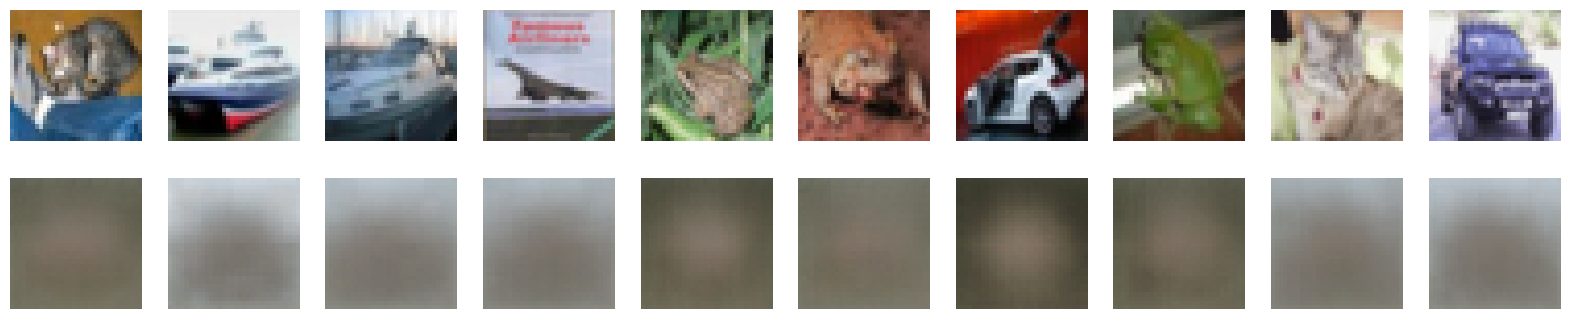

In [21]:
# Visualize
def plot_reconstructions(model, data):
    decoded_imgs = model.predict(data)
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i])
        plt.axis("off")

        # Reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.axis("off")
    plt.show()

plot_reconstructions(vae, x_test[:10])